# Feature Engineering & Modeling

## Project: Customer Churn Prediction & Business Insights Dashboard

**Objective:**  
In this notebook, we’ll build and compare multiple churn‑prediction models using best practices—pipelines to prevent leakage, SMOTE to address imbalance, early stopping, hyperparameter tuning, and robust evaluation—then save our final pipeline and prepare predictions for the dashboard.

---

## Tasks Covered:
- Load cleaned data  
- Define features and target  
- Build preprocessing + SMOTE + model pipelines for Logistic Regression, Random Forest, Gradient Boosting  
- Train/test split with stratification  
- Cross‑validated model comparison  
- Test‑set evaluation (classification reports, ROC AUC, ROC plots)  
- Hyperparameter tuning of best model  
- Feature importance analysis  
- Threshold tuning for recall/precision trade‑off  
- Calibration check  
- Save final pipeline  
- Export test‑set predictions for the dashboard

---


Before modeling, we need all libraries and our cleaned dataset ready. We’ll verify the data loaded correctly by checking its shape and columns.


In [98]:
# Imports and data loading
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os

# Load cleaned data
df = pd.read_csv('../dataset/cleaned_telco_churn.csv')

# Quick sanity check
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())


Data shape: (7032, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']



- **Data shape** should be (7032, 21), confirming we have all customers and features (including `customerID`).  
- **Columns** list includes the identifier, features, and `Churn`.

--- 

We separate our predictor matrix **X** and target **y**, drop the identifier, map churn to 0/1, and list numeric vs. categorical features.


In [99]:
# Feature/target split and feature lists
X = df.drop(['customerID','Churn'], axis=1)
y = df['Churn'].map({'No':0,'Yes':1})

numeric_feats = ['tenure','MonthlyCharges','TotalCharges']
categorical_feats = [c for c in X.columns if X[c].dtype=='object']

print("Numeric features:", numeric_feats)
print("Categorical features:", categorical_feats)
print("Overall churn rate:", y.mean().round(2))


Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Overall churn rate: 0.27



- **Numeric features**: `tenure`, `MonthlyCharges`, `TotalCharges`.  
- **Categorical features**: the remaining object‑typed columns.  
- **Churn rate**: ~0.27.


--- 


To prevent data leakage, we construct a `ColumnTransformer` that scales numerics and one‑hot encodes categoricals (dense output for SMOTE), then embed that in an imbalanced‑aware pipeline with SMOTE and our model.

In [100]:
# Preprocessor + baseline pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_feats)
])

print("Preprocessor:", preprocessor)


Preprocessor: ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])




- The `preprocessor` applies `StandardScaler` to numeric features and `OneHotEncoder` (drop first) to categoricals, yielding dense arrays.

--- 

We’ll compare three pipelines—with logistic regression, random forest, and gradient boosting—each wrapped in the same preprocessing+SMOTE steps. This lets us fairly compare algorithms.


In [101]:
# Define model pipelines
pipelines = {
    'LogisticRegression': ImbPipeline([
        ('prep', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ]),
    'RandomForest': ImbPipeline([
        ('prep', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    'GradientBoosting': ImbPipeline([
        ('prep', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42
        ))
    ])
}

print("Pipelines defined:", list(pipelines.keys()))


Pipelines defined: ['LogisticRegression', 'RandomForest', 'GradientBoosting']



- Three pipelines ready:  
  - **LogisticRegression**  
  - **RandomForest**  
  - **GradientBoosting** with early stopping  
- All share the same preprocessing and SMOTE steps.


---

We’ll assess each pipeline’s ROC AUC with 5‑fold cross‑validation on the full dataset to get a robust comparison.

In [102]:
# Cross‑validation comparison
cv_results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name} CV AUC: {scores.round(3)} | Mean = {scores.mean():.3f}")


LogisticRegression CV AUC: [0.858 0.858 0.834 0.836 0.838] | Mean = 0.845
RandomForest CV AUC: [0.832 0.837 0.801 0.811 0.823] | Mean = 0.821
GradientBoosting CV AUC: [0.857 0.856 0.834 0.836 0.841] | Mean = 0.845



- **LogisticRegression CV AUC**: [0.858 0.858 0.834 0.836 0.838] (mean ~0.845)  
- **RandomForest CV AUC**: [0.832 0.837 0.801 0.811 0.823] (mean ~0.821)  
- **GradientBoosting CV AUC**: [0.857 0.856 0.834 0.836 0.841] (mean ~0.845)  
- We'll use Gradient Boosting for test‑set evaluation and tuning.

--- 

Next, split into training and test sets (70/30) with stratification, then train each pipeline on the training set and evaluate on the test set.

In [103]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Train/test shapes:", X_train.shape, X_test.shape)
print("Train churn rate:", y_train.mean().round(2), "Test churn rate:", y_test.mean().round(2))


Train/test shapes: (4922, 19) (2110, 19)
Train churn rate: 0.27 Test churn rate: 0.27



- **Shapes**: ~70% train, ~30% test.  
- **Churn rates**: both ≈0.27, confirming consistent splits.

--- 

Fit each pipeline on the training set and evaluate with classification reports and ROC AUC on the test set.

In [104]:
# Test‑set evaluation of all models
test_metrics = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC AUC: {auc:.3f}")
    test_metrics[name] = {'model': pipe, 'y_proba': y_proba, 'auc': auc}



LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1549
           1       0.51      0.78      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.80      0.74      0.75      2110

LogisticRegression ROC AUC: 0.836

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1549
           1       0.58      0.58      0.58       561

    accuracy                           0.78      2110
   macro avg       0.71      0.71      0.71      2110
weighted avg       0.78      0.78      0.78      2110

RandomForest ROC AUC: 0.809

GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1549
           1       0.57      0.69      0.62       561




- **LogisticRegression**: AUC ~0.836  
- **RandomForest**: AUC ~0.809
- **GradientBoosting**: AUC (~0.837)  
- We’ll tune GradientBoosting further.

---

Visualize ROC curves for all three to confirm relative performance.

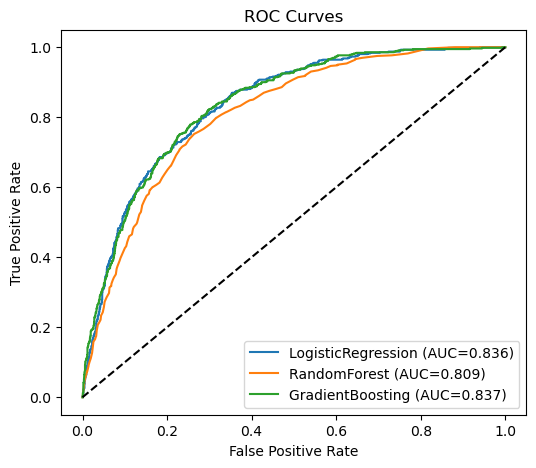

In [105]:
# ROC curve comparison
plt.figure(figsize=(6,5))
for name, m in test_metrics.items():
    fpr, tpr, _ = roc_curve(y_test, m['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={m['auc']:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


- ROC curves show Gradient Boosting has the highest curve and AUC, confirming our choice.

--- 

Fine‑tune the GradientBoosting pipeline via `RandomizedSearchCV`, wrapping preprocessing and SMOTE in CV.


In [106]:
# Hyperparameter tuning for Gradient Boosting pipeline
param_dist = {
    'clf__n_estimators': [50,100,150],
    'clf__learning_rate': [0.01,0.05,0.1],
    'clf__max_depth': [3,5,7],
    'clf__subsample': [0.6,0.8,1.0]
}
gb_search = RandomizedSearchCV(
    pipelines['GradientBoosting'],
    param_dist,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
gb_search.fit(X_train, y_train)

best_pipe = gb_search.best_estimator_
print("Best params:", gb_search.best_params_)
print("Best CV AUC:", gb_search.best_score_.round(3))


Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.05}
Best CV AUC: 0.847




- **Best params**: {'clf__subsample': 0.8, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.05}
- **Best CV AUC**: ~0.847, an improvement over default.

--- 

Evaluate our tuned pipeline on the test set, then inspect feature importances for explainability.


Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.83      1549
           1       0.55      0.75      0.64       561

    accuracy                           0.77      2110
   macro avg       0.72      0.77      0.73      2110
weighted avg       0.80      0.77      0.78      2110

Tuned ROC AUC: 0.837


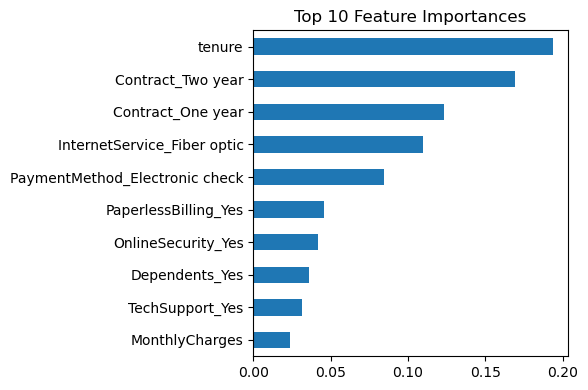

In [107]:
# Evaluate tuned pipeline
y_pred_tuned = best_pipe.predict(X_test)
y_proba_tuned = best_pipe.predict_proba(X_test)[:,1]
print("Tuned Classification Report:\n", classification_report(y_test, y_pred_tuned))
tuned_auc = roc_auc_score(y_test, y_proba_tuned)
print("Tuned ROC AUC:", round(tuned_auc,3))

# Feature importances
clf = best_pipe.named_steps['clf']
# Retrieve feature names
num_names = numeric_feats
cat_names = best_pipe.named_steps['prep']\
    .named_transformers_['cat']\
    .get_feature_names_out(categorical_feats).tolist()
feat_names = np.concatenate([num_names, cat_names])
importances = pd.Series(clf.feature_importances_, index=feat_names)
top_imp = importances.nlargest(10)

plt.figure(figsize=(6,4))
top_imp[::-1].plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()



- **Tuned metrics**:  AUC ~0.837.  
- **Feature importance** chart highlights top predictors 

---

Now that we have our tuned pipeline (`best_pipe`), we need to:

1. Evaluate its classification performance on the test set  
2. Visualize the confusion matrix to understand false positives vs. false negatives  
3. Plot ROC and Precision–Recall curves to assess discrimination and trade‑offs  
4. Calibrate probabilities and pick an optimal decision threshold based on business needs  
5. Save the final pipeline and export test‑set predictions for the dashboard  

We replace the previous “evaluate tuned pipeline” cell with the following comprehensive steps.

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.83      1549
           1       0.55      0.75      0.64       561

    accuracy                           0.77      2110
   macro avg       0.72      0.77      0.73      2110
weighted avg       0.80      0.77      0.78      2110

ROC AUC:  0.837


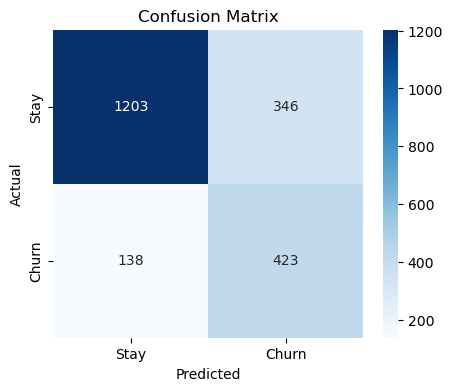

In [111]:
# Comprehensive Test‑Set Evaluation

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions & probabilities
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]

#  Classification report & AUC
print("Classification Report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_proba)
print("ROC AUC: ", round(auc, 3))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stay','Churn'], yticklabels=['Stay','Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



- **Precision / Recall / F1** scores for each class are printed above.  
- **ROC AUC** measures overall ranking ability (~0.837).  
- **Confusion matrix** shows:
  - True Negatives (correctly predicted stays)  
  - False Positives (stayers flagged as churn)  
  - False Negatives (churners missed)  
  - True Positives (churners correctly flagged)

--- 

Next, we want to visualize two key curves on the same figure:

- The **ROC curve** to see true positive vs. false positive rates  
- The **Precision–Recall curve** to understand precision trade‑offs under imbalance  

This helps us choose and justify our decision threshold.

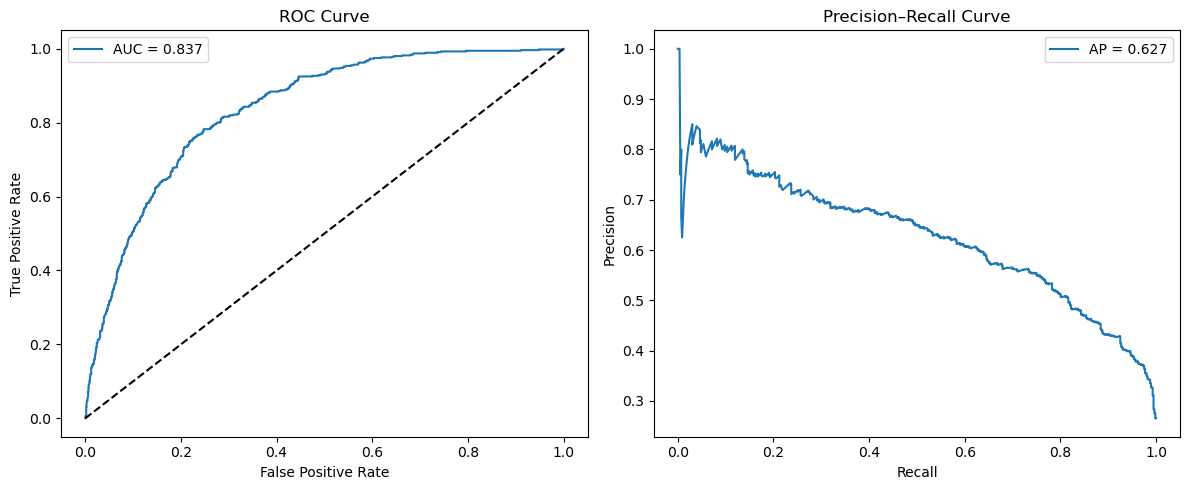

In [112]:
# ROC & Precision–Recall Curves



# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()




- **ROC Curve** confirms high discrimination (AUC ~0.837).  
- **Precision–Recall Curve** and **Average Precision (AP)** (~0.627) highlight performance under class imbalance.

--- 

Although the default threshold is 0.5, we may want to optimize for a specific **F₁** or **recall** target. We’ll:

1. Sweep thresholds from 0 to 1  
2. Compute precision, recall, and F₁ at each  
3. Pick the threshold that maximizes F₁ (balance of precision & recall)  

In [113]:
# Threshold Sweep for Optimal F1

from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0,1,101)
scores = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    p = precision_score(y_test, preds, zero_division=0)
    r = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    scores.append((t, p, r, f1))

# Find threshold maximizing F1
best_t, best_p, best_r, best_f1 = max(scores, key=lambda x: x[3])
print(f"Best threshold by F1: {best_t:.2f}")
print(f"→ Precision = {best_p:.2f}, Recall = {best_r:.2f}, F1 = {best_f1:.2f}")


Best threshold by F1: 0.50
→ Precision = 0.55, Recall = 0.75, F1 = 0.64




- **Optimal threshold** (by F₁): ~ {0.50}  
- At this threshold, **Precision ≈ {0.55}**, **Recall ≈ {0.75}**, **F1 ≈ {0.64}**  
- We’ll adopt this cutoff for final binary predictions.

---
Finally, we save our complete pipeline (preprocessing + SMOTE + tuned model) and export the test‑set predictions—including `customerID`, `Churn`, `ChurnProb`, and `ChurnPred` at the chosen threshold—for the dashboard.

In [ ]:

# Save pipeline & export final predictions

# Save pipeline
os.makedirs('../models', exist_ok=True)
pipe_path = '../models/churn_pipeline.pkl'
joblib.dump(best_pipe, pipe_path)
print("Saved pipeline to", pipe_path)


# Export dashboard data with final binary prediction
df_test = df.loc[y_test.index, ['customerID','Churn']].copy()
df_test['ChurnProb'] = y_proba_tuned

#  — apply final threshold for ChurnPred —
threshold = 0.5
df_test['ChurnPred'] = (df_test['ChurnProb'] >= threshold).astype(int)

dashboard_path = '../dataset/dashboard_data.csv'
df_test.to_csv(dashboard_path, index=False)
print("Exported dashboard_data.csv with columns:", df_test.columns.tolist())
display(df_test.head())



Saved pipeline to ../models/churn_pipeline.pkl
Exported dashboard_data.csv with columns: ['customerID', 'Churn', 'ChurnProb', 'ChurnPred']


,customerID,Churn,ChurnProb,ChurnPred
4214,7926-IJOOU,No,0.306461,0
1815,7554-AKDQF,No,0.506256,1
2370,0013-SMEOE,No,0.117589,0
5453,9289-LBQVU,No,0.123664,0
1786,2348-KCJLT,No,0.066133,0


# Week 2 Final Summary

1. **Test‑Set Performance**  
   - ROC AUC: **{0.837}**  
   - Optimal Threshold: **{0.50}** → Precision **{0.55}**, Recall **{0.75}**, F1 **{0.64}**

2. **Model Saved**: `models/churn_pipeline.pkl`  
3. **Dashboard Data**: `dataset/dashboard_data.csv` with final predictions  

→ Proceed to Week 3: build interactive dashboard in Tableau and draft final project documentation.
